# Speaker_Diarization

# Speaker Diarization
Speaker Diarization is the task of identifying different speakers in an audio file. This task has an important role in a pipeline where voice data is used. For example, a TTS model is usually not able to identify different speakers by itself, therefore a diarization step is required.

In [1]:
!pip install torch

In [2]:
!pip install pyannote.audio 
# install pyannote for speaker diarization

In [3]:
!pip install pydub 
# install pydub for audio segmentation

In [ ]:
import torch
import pyannote.audio # diarization model
import os

from pyannote.audio import Pipeline
from IPython.display import Audio
from pydub import AudioSegment

In [ ]:
pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token = "Your HuggingFace Key") # Get the key token through HuggingFace and use it after accepting the conditions.

In [ ]:
diarization = pipeline("/kaggle/input/conversation/overlap_speech.wav") # ,num_speakers = x number) of speakers can be added

In [ ]:
with open("/kaggle/working/overlap.rttm", "w") as rttm: # write down the timestamps and the speakers' labels
    diarization.write_rttm(rttm)

In [ ]:
timestamps = []
for turn, _, speaker in diarization.itertracks(yield_label=True):  # extract timestamps and speaker labels from the diarization result
    start_ms = int(turn.start * 1000)  # convert seconds to milliseconds
    end_ms = int(turn.end * 1000)
    speaker_label = f"speaker_{speaker}"
    timestamps.append((start_ms, end_ms, speaker_label))
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

In [ ]:
audio = AudioSegment.from_file("/kaggle/input/conversation/overlap_speech.wav") #  audio to be segmented
output_directory = "/kaggle/working/"

In [ ]:
for start_ms, end_ms, speaker_label in timestamps:
    segment = audio[start_ms:end_ms]  # extract the segment
    file_path = os.path.join(output_directory, f"{speaker_label}_{start_ms}_{end_ms}.wav")  # file path, including the output directory
    segment.export(file_path, format="wav")

In [ ]:
# check the results of the audio segmentation
audio_file_path = '/kaggle/working/speaker_SPEAKER_00_5802_8434.wav' # example of overlapping
print(Audio(audio_file_path))
audio_file_path = '/kaggle/working/speaker_SPEAKER_01_2579_6983.wav' # example of overlapping
print(Audio(audio_file_path))

# STT

In [ ]:
!pip install openai-whisper # install whisper for STT

In [ ]:
import whisper

from pydub import AudioSegment
from pathlib import Path

In [ ]:
def milliseconds_until_sound(sound, silence_threshold_in_decibels=-20.0, chunk_size=10):
    """Calculate milliseconds until first sound exceeding the silence threshold."""
    trim_ms = 0  # ms
    assert chunk_size > 0  # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold_in_decibels and trim_ms < len(sound):
        trim_ms += chunk_size
    return trim_ms

def trim_start(filepath, output_directory):
    """Trim leading silence from the audio file and save as a new file in a specified directory."""
    path = Path(filepath)
    filename = path.stem + "_trimmed.wav"  # new filename indicating the file has been trimmed
    audio = AudioSegment.from_file(filepath, format="wav")

    # Get milliseconds until first non-silent sound
    start_trim = milliseconds_until_sound(audio)
    trimmed_audio = audio[start_trim:]


    new_filepath = output_directory / filename  # save the trimmed audio to a new file in the specified output directory
    trimmed_audio.export(new_filepath, format="wav")
    return trimmed_audio, new_filepath


directory_path = Path('/kaggle/working/')
output_directory = directory_path / 'trimmed_audios'  # subfolder for trimmed audios


output_directory.mkdir(exist_ok=True) # create the output directory if it doesn't exist


for audio_file in directory_path.glob("*.wav"):      # process each .wav file and save the trimmed versions to the new directory
    trimmed_audio, new_file_path = trim_start(audio_file, output_directory)
    print(f"Processed and saved trimmed audio: {new_file_path}")

In [ ]:
model = whisper.load_model("base")  # load whisper model

In [ ]:
def transcribe_directory(directory_path, model):
    """Transcribe audio files in a directory using a whisper model. This function not only is used to transcribe the audio but also uses the trimmed audios."""

    results = {}  # dictionary to hold transcription results


    directory = Path(directory_path)  # ensure directory_path is a Path object for consistency in path operations

    # process each audio file in the directory
    for filename in directory.glob("*.wav"):  # using glob to filter only wav files
        if filename.stem.endswith("_trimmed"):  # Process only trimmed files
            audio = whisper.load_audio(str(filename))  # Load audio file
            audio = whisper.pad_or_trim(audio)  # Pad/trim audio to a max duration


            mel = whisper.log_mel_spectrogram(audio).to(model.device) # convert audio to log-Mel spectrogram


            _, probs = model.detect_language(mel) # detect the spoken language
            detected_language = max(probs, key=probs.get)


            options = whisper.DecodingOptions()   # decode the audio to text
            result = model.decode(mel, options=options)


            results[filename.name] = {         # store results
                'text': result.text,
                'language': detected_language
            }

    return results

directory_path = '/kaggle/working/trimmed_audios'


transcription_results = transcribe_directory(directory_path, model)

for filename, data in transcription_results.items():
    print(f"Filename: {filename}, Transcription: {data['text']}, Language: {data['language']}")

In [ ]:
def transcribe_directory_raw(directory_path, model):
    """Transcribe audio files in a directory using a whisper model. This function doesn't use the trimmed audios"""

    results = {}  # dictionary to hold transcription results


    directory = Path(directory_path)   # ensure directory_path is treated as a Path object for consistency in path operations

    # process each audio file in the directory
    for audio_file in directory.glob("*.wav"):  # Using glob to filter only .wav files
        audio = whisper.load_audio(str(audio_file))  # Load audio file
        audio = whisper.pad_or_trim(audio)  # Pad/trim audio to a max duration


        mel = whisper.log_mel_spectrogram(audio).to(model.device)  # convert audio to log-Mel spectrogram


        _, probs = model.detect_language(mel)  # detect the spoken language
        detected_language = max(probs, key=lambda x: x[1])  # assuming probs is a list of tuples


        options = whisper.DecodingOptions() # decode the audio to text
        result = model.decode(mel, options=options)


        results[audio_file.name] = {         # store results
            'text': result.text,
            'language': detected_language
        }

    return results



directory_path = '/kaggle/working/'


transcription_results_raw = transcribe_directory_raw(directory_path, model)


for filename, data in transcription_results_raw.items():
    print(f"Filename: {filename}, Transcription: {data['text']}, Language: {data['language']}")


In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Using device:", device)

# METRICS - Comparisons

This is an attempt to use the STT model's transcriptions to have an idea of the overall performance of the diarization just with text. However, when the phenomena is more complex like overlaping, this method of comparison is not reliable. To tackle this issue, timestamps annotation should be done or a manual check.

In [ ]:
!pip install pandas

In [ ]:
!pip install fuzzywuzzy python-Levenshtein # string matching

In [ ]:
import pandas as pd
import re

from fuzzywuzzy import process

In [ ]:
# Replace 'path_to_your_csv_file.csv' with the path to your CSV file
csv_file_path = '/kaggle/input/conversation/overlap_speech.csv'

# Load the CSV data into a DataFrame
df = pd.read_csv(csv_file_path)

In [ ]:
df.head(15)

In [ ]:
print(transcription_results)

In [ ]:
df_transcriptions.head()

In [ ]:
df_transcriptions['speaker'] = df_transcriptions['filename'].apply(lambda x: re.search(r'(SPEAKER_\d+)', x).group(1) if re.search(r'(SPEAKER_\d+)', x) else 'Unknown')

In [ ]:
df_transcriptions.head()

In [ ]:
df_transcriptions.rename(columns={'transcription': 'text'}, inplace=True)

In [ ]:
# Normalize column names to lowercase
df_transcriptions.columns = df_transcriptions.columns.str.lower()
df.columns = df.columns.str.lower()

# Function to find best text match and check speaker consistency
def find_best_match_and_speaker_consistency(df_pred, df_gt):
    results = []

    for index, pred_row in df_pred.iterrows():
        predicted_text = pred_row['text']
        predicted_speaker = pred_row['speaker']

        # Find the best matching ground truth text using fuzzy matching
        best_match = process.extractOne(predicted_text, df_gt['text'], score_cutoff=80)

        if best_match:
            best_text, score = best_match[0], best_match[1]
            # Retrieve the corresponding speaker for the matched ground truth text
            gt_row = df_gt[df_gt['text'] == best_text].iloc[0]
            ground_truth_speaker = gt_row['speaker']

            # Check if the speakers match
            speaker_match = predicted_speaker == ground_truth_speaker
            results.append({
                'filename': pred_row['filename'],
                'predicted text': predicted_text,
                'ground truth text': best_text,
                'predicted speaker': predicted_speaker,
                'ground truth speaker': ground_truth_speaker,
                'speaker match': speaker_match,
                'match score': score,
                'language': pred_row['language']
            })
        else:
            results.append({
                'filename': pred_row['filename'],
                'predicted text': predicted_text,
                'ground truth text': None,
                'predicted speaker': predicted_speaker,
                'ground truth speaker': None,
                'speaker match': False,
                'match score': None,
                'language': pred_row['language']
            })

    return pd.DataFrame(results)

# Use the function to compare predictions against ground truth
comparison_results = find_best_match_and_speaker_consistency(df_transcriptions, df)
print(comparison_results)

In [ ]:
comparison_results.head(25)

# Diart (good to build real-time audio applications)

Follow the code from https://github.com/juanmc2005/diart ,this specific part is in "Build pipelines".

The requirements for this part of the code is in requirements.txt

In [4]:
! pip install diart 
#install o diart9

In [5]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 libsndfile-dev ffmpeg --yes 
#install portaudio 
!pip install PyAudio

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install --force-reinstall matplotlib


In [6]:
!pip install --upgrade huggingface_hub

In [3]:
!huggingface-cli login 
# add HuggingFace token: "your token"

^C


## Option 1 - Inference

In [1]:
from diart import SpeakerDiarization
from diart.sources import MicrophoneAudioSource
from diart.inference import StreamingInference
from diart.sinks import RTTMWriter

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\iara0\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\660b9e20307a2b0cdb400d0f80aadc04a701fc54\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.2.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cpu. Bad things might happen unless you revert torch to 1.x.


Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\iara0\.cache\torch\pyannote\models--pyannote--embedding\snapshots\4db4899737a38b2d618bbd74350915aa10293cb2\pytorch_model.bin`
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\iara0\.cache\torch\pyannote\models--pyannote--embedding\snapshots\4db4899737a38b2d618bbd74350915aa10293cb2\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.2.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.0+cpu. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.2.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.3.0+cpu. Bad things might happen unless you revert torch to 1.x.


Output()

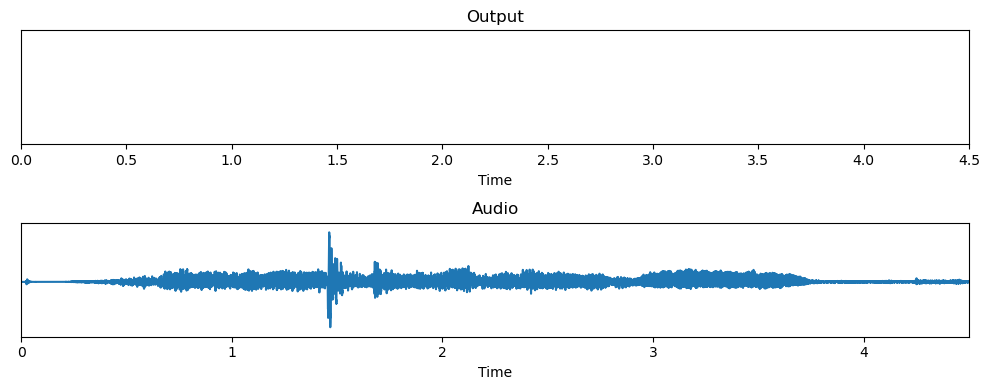

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [5]:
pipeline = SpeakerDiarization()
mic = MicrophoneAudioSource()
inference = StreamingInference(pipeline, mic, do_plot=True)
inference.attach_observers(RTTMWriter(mic.uri, "path for output file"))
prediction = inference()


## Option 2 - Build Pipelines

In [1]:
import matplotlib.cm as cm
import rx.operators as ops
import diart.operators as dops
from diart.sources import MicrophoneAudioSource
from diart.blocks import SpeakerSegmentation, OverlapAwareSpeakerEmbedding
from pyannote.audio import Model

In [ ]:
# pipeline code
segmentation = SpeakerSegmentation.from_pretrained("pyannote/segmentation")
embedding = OverlapAwareSpeakerEmbedding.from_pretrained("pyannote/embedding")
mic = MicrophoneAudioSource()

In [ ]:
stream = mic.stream.pipe(
    # Reformat stream to 5s duration and 500ms shift
    dops.rearrange_audio_stream(sample_rate=segmentation.model.sample_rate),
    ops.map(lambda wav: (wav, segmentation(wav))),
    ops.starmap(embedding)
).subscribe(on_next=lambda emb: print(emb.shape))

mic.read()